In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from stack_segmentation.stack import Stack

In [5]:
from stack_segmentation.io import make_dataloader, collate_fn_basic

from stack_segmentation.training import (
    handle_stacks_data, 
    make_optimization_task, 
    train_loop
)

from stack_segmentation.pipeline_config import (
    dataloaders_conf,
    train_conf,
    model_config, 
    aug_config,
    optimizer_config,
    loss_config,
    scheduler_config,
)

In [6]:
from exp_config import data_conf

## Parameters to tune

In [7]:
train_conf['device'] = 'cuda:1'
# train_conf['device'] = 'cpu'
train_conf['num_epochs'] = 500
train_conf

{'num_epochs': 500, 'device': 'cuda:1'}

In [8]:
data_conf['conf_name'] = 'exp_basic_adamw_lr1e-3_epoch_300_senet154_encoder_soft_aug_k_1_weight10_patch64'
data_conf['patches'] = {
    'train': (64, 64, 1),
    'val': (64, 64, 1),
    'test': (64, 64, 1)
}
data_conf

{'conf_name': 'exp_basic_adamw_lr1e-3_epoch_300_senet154_encoder_soft_aug_k_1_weight10_patch64',
 'stacks': [{'path': '../../data/carb96558',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(250, 470, None))},
  {'path': '../../data/SoilB-2',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(240, 460, None))},
  {'path': '../../data/Urna_22',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 220, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(245, 455, None))},
  {'path': '../../data/carb96558',
   'slice_test': (slice(None, None, None),
    slice(None, None, None),
    slice(490, None, None))},
  {'path': '../../data/carb71',
   'slice_test': 

In [9]:
model_config['encoder_name'] = 'senet154'
model_config

{'source': 'qubvel',
 'model_type': 'Unet',
 'encoder_name': 'senet154',
 'encoder_weights': 'imagenet'}

In [10]:
optimizer_config['opt_type'] = 'AdamW'
optimizer_config['lr'] = 1e-3
optimizer_config['weight_decay'] = 5e-5
optimizer_config['amsgrad'] = True
# optimizer_config['nesterov'] = True
optimizer_config

{'opt_type': 'AdamW',
 'lr': 0.001,
 'weight_decay': 5e-05,
 'amsgrad': True,
 'nesterov': False,
 'momentum': 0.9,
 'centered': False}

In [11]:
aug_config['aug_type'] = 'soft'
aug_config['k'] = 1
aug_config['original_height'] = 64
aug_config['original_width'] = 64
aug_config

{'aug_type': 'soft', 'original_height': 64, 'original_width': 64, 'k': 1}

In [12]:
loss_config =[
    {
        'loss': 'BCE', 
        'weight': 1, 
        'params': {'weight': [1, 10]}},
    {
        'loss': 'Dice',
        'weight': 2, 
        'params': {
            'mode': 'multiclass',
            'classes': [1], # может быть, этот параметр не нужен
            'log_loss': True,
            'from_logits': True,
            'smooth': 1,
            'eps': 1e-7
        }
    }
]
loss_config

[{'loss': 'BCE', 'weight': 1, 'params': {'weight': [1, 10]}},
 {'loss': 'Dice',
  'weight': 2,
  'params': {'mode': 'multiclass',
   'classes': [1],
   'log_loss': True,
   'from_logits': True,
   'smooth': 1,
   'eps': 1e-07}}]

In [13]:
dataloaders_conf['train']['batch_size'] = 96
dataloaders_conf['val']['batch_size'] = 96
dataloaders_conf['test']['batch_size'] = 96
dataloaders_conf

{'train': {'batch_size': 96, 'num_workers': 16, 'shuffle': True},
 'val': {'batch_size': 96, 'num_workers': 16, 'shuffle': False},
 'test': {'batch_size': 96, 'num_workers': 16, 'shuffle': True}}

## Prepare train, validation and test data

In [14]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:01, 664.05it/s]
100%|██████████| 720/720 [00:07<00:00, 92.26it/s] 
33120it [00:00, 241955.05it/s]
31680it [00:00, 161372.87it/s]
700it [00:00, 829.00it/s]
100%|██████████| 700/700 [00:06<00:00, 101.77it/s]
27830it [00:00, 142403.38it/s]
26620it [00:00, 238074.91it/s]
710it [00:00, 833.25it/s]
100%|██████████| 710/710 [00:07<00:00, 98.60it/s] 
31680it [00:00, 140482.39it/s]
30240it [00:00, 130610.66it/s]
720it [00:00, 803.26it/s]
100%|██████████| 720/720 [00:07<00:00, 97.26it/s] 
33120it [00:00, 246563.05it/s]
720it [00:00, 799.82it/s]
100%|██████████| 720/720 [00:07<00:00, 94.99it/s] 
103680it [00:00, 172981.08it/s]
700it [00:01, 671.46it/s]
100%|██████████| 700/700 [00:07<00:00, 99.65it/s] 
84700it [00:00, 218461.93it/s]
509it [00:00, 1135.27it/s]
100%|██████████| 509/509 [00:02<00:00, 191.28it/s]
32576it [00:00, 90099.51it/s]
700it [00:00, 826.74it/s]
100%|██████████| 700/700 [00:07<00:00, 98.41it/s] 
84700it [00:00, 209298.83it/s]
700it [00:00, 775.52it/s]
100%|██████████|

In [15]:
len(data_train), len(data_val), len(data_test)

(92630, 88540, 11)

In [16]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    aug_config=aug_config,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        model_config=model_config,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [17]:
device = 'cuda:1'
# device = 'cpu'

In [18]:
model, criterion, optimizer, scheduler = make_optimization_task(
    device,
    model_config=model_config,
    loss_config=loss_config, 
    optimizer_config=optimizer_config,
    scheduler_config=scheduler_config)

## Run experiment

In [19]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [20]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [ ]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    **train_conf)

  0%|          | 0/965 [00:00<?, ?it/s]

Epoch 0...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.070332


100%|██████████| 923/923 [02:24<00:00,  6.37it/s]


Mean val loss: 0.031939


  0%|          | 0/965 [00:00<?, ?it/s]

Epoch 1...


  0%|          | 0/923 [00:00<?, ?it/s]

Mean train loss: 0.030838


  0%|          | 0/965 [00:00<?, ?it/s]

Mean val loss: 0.03252
EarlyStopping counter: 1 out of 15
Epoch 2...


 31%|███       | 295/965 [03:27<07:46,  1.44it/s]

## Dump experiment results

In [40]:
import pickle
import json

In [41]:
p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
with open(p, 'wb') as f:
    pickle.dump(results, f)

In [28]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'rb') as f:
#     results = pickle.load(f)

In [11]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Train and validation losses

In [42]:
from itertools import chain

In [43]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [44]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

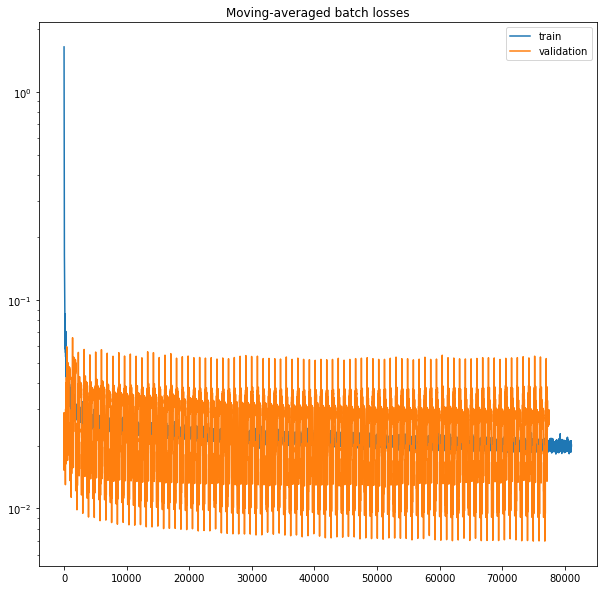

In [45]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [46]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

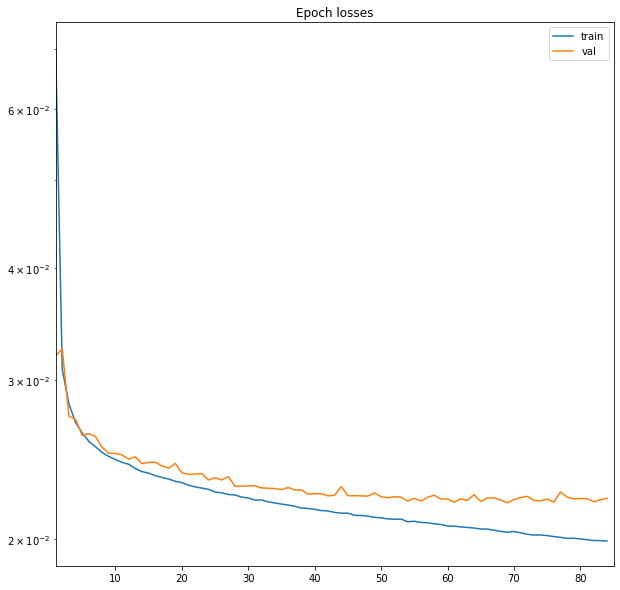

In [47]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

## Results

In [48]:
import pandas as pd

In [49]:
from visualization_utils import make_df

In [50]:
df = make_df(results, model_name='basic')
df

,accuracy,precision,recall,f1,pr_auc,iou,stack,model
0,0.995783,0.954073,0.996358,0.974757,0.998735,0.950757,carb96558,basic
1,0.986041,0.900567,0.993301,0.944663,0.993108,0.895130,carb71,basic
2,0.979370,0.918460,0.923025,0.920737,0.974437,0.853116,carbRNF,basic
3,0.995468,0.991045,0.952430,0.971354,0.996842,0.944304,SPE_carb10_58_box3,basic
4,0.990819,0.956308,0.932637,0.944324,0.991007,0.894521,SoilAh-1,basic
5,0.994428,0.925467,0.994080,0.958547,0.997495,0.920394,SoilB-2,basic
6,0.990420,0.993673,0.930050,0.960810,0.982952,0.924576,TeTree_subset1,basic
7,0.994105,0.993503,0.948459,0.970459,0.986710,0.942612,TiTree_subset2,basic
8,0.992429,0.947041,0.996266,0.971030,0.998339,0.943691,Urna_22,basic
9,0.990491,0.956698,0.986098,0.971176,0.997949,0.943967,Urna_30,basic


In [51]:
print('Mean   IOU: {:.5}'.format(df['iou'].mean()))
print('Std    IOU: {:.5}'.format(df['iou'].std()))
print('Min    IOU: {:.5}'.format(df['iou'].min()))
print('Median IOU: {:.5}'.format(df['iou'].median()))

Mean   IOU: 0.92068
Std    IOU: 0.029954
Min    IOU: 0.85312
Median IOU: 0.92458


## Check loss to loss ratio

In [52]:
criterion.losses

(WeightedLoss(
   (loss): CrossEntropyLoss()
 ), WeightedLoss(
   (loss): DiceLoss()
 ))

In [53]:
from stack_segmentation.training import make_joint_loss

In [54]:
import torch

In [55]:
# loss_config[0] = {'loss': 'BCE',
#   'weight': 0.5,
#   'params': {}}
# loss_config
# crit = make_joint_loss(device=device, loss_config=loss_config)

In [56]:
crit = criterion
a = []
b = []
for i, (x, y) in enumerate(dataloader_val):
    if i > 100:
        break
    pred = model(torch.from_numpy(x).to(device))
    y = torch.from_numpy(y).to(device)
    a.append(crit.losses[0](pred, y).cpu().data.numpy())
    b.append(crit.losses[1](pred, y).cpu().data.numpy())

In [57]:
print('Mean 0 loss: {:.4f}\nMean 1 loss: {:.4f}\nMean of ratios: {:.4f}\nRatio of means: {:.4f}'
      .format(np.mean(a), np.mean(b), np.mean(np.array(a) / np.array(b)), np.mean(a) / np.mean(b)))

Mean 0 loss: 0.0092
Mean 1 loss: 0.0039
Mean of ratios: 2.5470
Ratio of means: 2.3559
